In [1]:
import pandas as pd

# Load datasets
customers = pd.read_csv(r'C:\Users\kranthi kumar goli\Downloads\Customers.csv')
transactions = pd.read_csv(r'C:\Users\kranthi kumar goli\Downloads\Transactions.csv')

# Merge datasets
data = transactions.merge(customers, on="CustomerID", how="left")


In [2]:
# Create features
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['SignupDate'] = pd.to_datetime(data['SignupDate'])

customer_features = (
    data.groupby("CustomerID")
    .agg(
        total_spending=("TotalValue", "sum"),
        avg_spending=("TotalValue", "mean"),
        num_transactions=("TransactionID", "count"),
        signup_year=("SignupDate", lambda x: x.dt.year.mode()[0]),
    )
    .reset_index()
)

# One-hot encode the region
region_dummies = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'], drop_first=True)
customer_features = customer_features.merge(region_dummies, on="CustomerID", how="left")


In [3]:
from sklearn.preprocessing import StandardScaler

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['total_spending', 'avg_spending', 'num_transactions', 'signup_year']
customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Choose the number of clusters (e.g., 3 to 6)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[numerical_features])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(customer_features[numerical_features], customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 1.1224487156406988


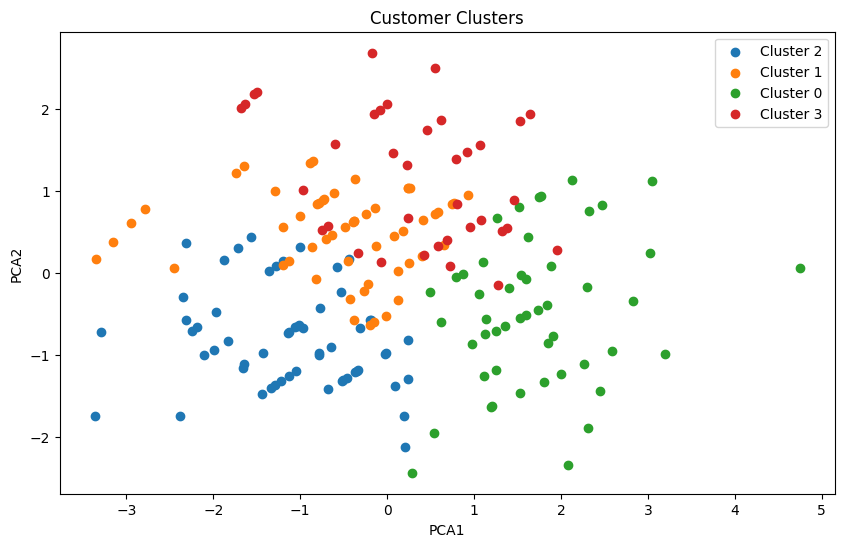

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_features[numerical_features])

# Add PCA results to the dataset
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in customer_features['Cluster'].unique():
    cluster_data = customer_features[customer_features['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
    
plt.title("Customer Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()


In [6]:
# Save the clustering results
customer_features[['CustomerID', 'Cluster']].to_csv("kiranKumar_goli_Clustering.csv", index=False)

# Save DB Index value in the PDF report
print(f"The Davies-Bouldin Index for {num_clusters} clusters is: {db_index}")

The Davies-Bouldin Index for 4 clusters is: 1.1224487156406988
